<div style="direction:rtl;line-height:300%;">
<font face="XB Zar" size=5>
<div align=center>
<font face="B Titr" size=5>
<p></p><p></p>
بسمه تعالی
<p></p>
</font>
<p></p>
<font>
<br>
درس بازیابی پیشرفته اطلاعات
<br>
مدرس: دکتر بیگی
</font>
<p></p>
<br>
<font>
<b>تمرین سوم</b>
</font>
<br>
<br>
موعد تحویل: ۴ دی <br>
<br>
<br>
<br>
<font>
دانشگاه صنعتی شریف
<br>
دانشکده مهندسی کامپیوتر
<br>
<br>
</font>
</div>
</font>
</div>

<span style="color: red;">
<div dir='rtl'>

<b> نام و نام‌‌خانوادگی:  </b>
<!-- YOUR NAME HERE -->

<b> شماره دانشجویی:  </b>
<!-- YOUR STUDENT ID HERE -->

<b> لینک colab:  </b>

<!-- UPLOAD YOUR NOTEBOOK TO GOOGLE COLAB AND MAKE SURE TO RUN ALL OF ITS CELLS -->
</div>
</span>

<div dir='rtl'>
<h1>
مقدمه
</h1>
<p>
در این تمرین قصد داریم به مباحث زیر بپردازیم:
<li> embedding </li>
<li> کلاسه‌بندی متن </li>
<li> کاهش ابعاد </li>
<li> خوشه‌بندی متن و هرس‌کردن خوشه‌ها</li>

دیتاست این تمرین از دیتاست‌های kaggle انتخاب شده‌است و لینک آن در بخش اول تمرین در اختیار شما قرار داده شده است.

کتابخانه‌های مورد نظرتان را هم می‌توانید در اولین سل نوت‌بوک فراخوانی کنید.
</p>
</div>

In [1]:
!pip install opendatasets
!pip install FastText

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 613.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for FastText: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199772 sha256=8fb4a3c9587b820f3feba6ab4a4fbe9f24059b51a678b2d282bea6cd920aecc0
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built FastText


In [3]:
import opendatasets as od
import kaggle
import pandas as pd
import numpy as np
import string
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import fasttext
import sklearn
from copy import deepcopy
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
import string
import zipfile


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<div dir='rtl'>
<h1>1.
دریافت و آماده‌سازی دیتاست
</h1>
<p>
دیتاست استفاده شده در این تمرین، مجموعه‌ای عناوین، خلاصه، و ژانر چندین کتاب است.
این دیتاست در kaggle موجود است.
ابتدا این دیتاست را با استفاده از kaggle api دریافت کنید و سپس آن را لود کنید.
<br/>
لینک دیتاست: https://www.kaggle.com/datasets/athu1105/book-genre-prediction
<br>
<i>در صورتی که با خطای 443 مواجه شدید، یا از پراکسی استفاده کنید یا از کولب.</i>
</p>
</div>

In [4]:
# TODO: Download Dataset (https://www.kaggle.com/datasets/athu1105/book-genre-prediction) Using Kaggle API
!kaggle datasets download -d athu1105/book-genre-prediction

zip_file_path = '/content/book-genre-prediction.zip'
destination_folder = '/content/extracted_files'
zip_ref = zipfile.ZipFile(zip_file_path, 'r')
zip_ref.extractall(destination_folder)
zip_ref.close()

  0% 0.00/3.73M [00:00<?, ?B/s]
100% 3.73M/3.73M [00:00<00:00, 114MB/s]


In [5]:
# TODO: Load Dataset into df
data_frame = pd.read_csv('/content/extracted_files/data.csv')
data_frame.head()

,index,title,genre,summary
0,0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...
1,1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ..."
2,2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...
3,3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...
4,4,Taran Wanderer,fantasy,Taran and Gurgi have returned to Caer Dallben...


In [10]:
# TODO: Perform data cleaning and eda (you can add cells here)
data_frame = data_frame.dropna()

<div dir='rtl'>
<p>
حال در این مرحله، به پیش‌پردازش متن می‌پردازیم. این پیش‌پردازش باید روی هر دو ستون title و summary اعمال شود.
برای پیش‌پردازش نیازی نیست که هرکدام از اعمال پیش‌پردازش را خودتان مانند تمارین قبل پیاده کنید. برای پیاده‌سازی تابع زیر می‌توانید از کتابخانه‌های معمول برای این کار بهره ببرید.
</p>
</div>

In [11]:


def preprocess_text(text, minimum_length=1, stopword_removal=True, stopwords_domain=[], lower_case=True,
                       punctuation_removal=True):
    """
    preprocess text by removing stopwords, punctuations, and converting to lowercase, and also filter based on a min length
    for stopwords use nltk.corpus.stopwords.words('english')
    for punctuations use string.punctuation
    Parameters
    ----------
    text: str
        text to be preprocessed
    minimum_length: int
        minimum length of the token
    stopword_removal: bool
        whether to remove stopwords
    stopwords_domain: list
        list of stopwords to be removed base on domain
    lower_case: bool
        whether to convert to lowercase
    punctuation_removal: bool
        whether to remove punctuations
    """

    tokens = word_tokenize(text)

    if lower_case:
        tokens = [token.lower() for token in tokens]

    if stopword_removal:
        if stopwords_domain:
            stop_words = set(stopwords.words('english')).union(set(stopwords_domain))
        else:
            stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]

    if punctuation_removal:
        tokens = [token for token in tokens if token not in string.punctuation]

    tokens = [token for token in tokens if len(token) >= minimum_length]

    return tokens

text = "This is an Example Sentence for Text Preprocessing."
preprocessed_tokens = preprocess_text(text)
print(preprocessed_tokens)

['example', 'sentence', 'text', 'preprocessing']


In [12]:
# TODO: Apply preprocess text on both title and summary columns
df = deepcopy(data_frame)
df['title'] = df['title'].apply(preprocess_text)
df['summary'] = df['summary'].apply(preprocess_text)

<div dir="rtl">
در نهایت بعد از اپلای کردن پیش‌پردازش روی هر دو ستون، دو ستون پیش‌پردازش شده را با هم ادغام کنید و آن را در یک آرایه به نام X قرار دهید.
</div>

In [13]:
# TODO: Merge preprocessed columns
X_title = df['title'].tolist()
X_summary = df['summary'].tolist()
X = [' '.join(title) + ' '.join(summary) for title, summary in zip(X_title, X_summary)]


In [14]:
print(X[1])

lost herobook opens jason awakens school bus unable remember anything past sitting next piper mclean leo valdez call name say girlfriend best friend respectively three part class field trip grand canyon arrive classmate dylan turns venti storm spirit attacks trio trip leader coach gleeson hedge ensuing fight jason surprises everyone including one coins turns sword uses battle storm spirits coach hedge reveals satyr fight taken captive fleeing spirit battle flying chariot arrives rescue trio one people annabeth upset discovers missing boyfriend percy jackson expected annabeth seeking percy told vision goddess hera look `` guy one shoe '' turns jason shoe destroyed fight jason piper leo told demigods taken back camp half-blood meet greek demigod children like leo revealed son hephaestus piper daughter aphrodite jason son zeus though hera tells champion jason later discovers full brother zeus 's demigod daughter thalia grace hunter artemis shortly arrive three given quest rescue hera capt

<div dir="rtl">
<h2>1-1.
Embedding
</h2>

در این قسمت از fasttext کمک می‌گیریم تا به یک embedding اولیه برای هر کتاب برسیم.
    با استفاده از داده‌هایی که داریم یک مدل fasttext آموزش دهید که برای هر توکن یک امبدینگ ۱۰۰تایی بدهد.
    در مرحله‌ی بعد میانگین وزن دار امبدینگ های fasttext
        توکن‌های ورودی (چکیده + عنوان)
    را بر اساس tfidif آن‌ها محاسبه کنید و به امبدینگ نهایی متن برسید.
    <br>
    در واقع به عبارت ساده‌تر بر اساس میانگین وزن‌دار که وزن‌های ما tfidf توکن‌ها می‌باشد به امبدینگ نهایی متن بر اساس fasttext می‌رسیم.
</div>

In [15]:
class FastText:

    def __init__(self, preprocessor=None, method='skipgram'):
        self.method = method
        self.model = None
        self.preprocessor = preprocessor

    def train(self, texts):
        """
        train the fasttext model and save it into self.model
        Parameters
        ----------
        texts: list of list of str
        """
        print(texts[0:5])
        if self.preprocessor:
            print(' '.join(self.preprocessor(texts[0])))
            texts = [' '.join(self.preprocessor(text)) for text in texts]
        print(texts[0:5])


        with open('temp_text_file.txt', 'w', encoding='utf-8') as f:
            for text in texts:
                f.write(text + '\n')

        self.model = fasttext.train_unsupervised('temp_text_file.txt', model=self.method)

        # self.save_FastText_model()

    def get_query_embedding(self, query, tf_idf_vectorizer):
        """
        get the embedding of the query. You can use the tf_idf_vectorizer to get the weights of the words in the query. preprocess the query using self.preprocessor if it is not None
        Parameters
        ----------
        query: str
        tf_idf_vectorizer: TfidfVectorizer
        Returns embedding of the query
        """
        if self.preprocessor:
            words = self.preprocessor(query)
        else:
            words = query.split()

        vectorized_query = tf_idf_vectorizer.transform([' '.join(words)])
        vocab = tf_idf_vectorizer.vocabulary_
        weights = np.array([vectorized_query[0, vocab[word]] for word in words])
        query_embed = (weights.reshape((-1, 1)) * np.array([self.model.get_word_vector(r) for r in words])).sum(axis=0) / weights.sum()
        return query_embed

    def save_FastText_model(self, path='FastText_model.bin'):
        self.model.save_model(path)

    def load_FastText_model(self, path="FastText_model.bin"):
        self.model = fasttext.load_model(path)

    def prepare(self, dataset, mode, save=False):
        if mode == 'train':
            self.train(dataset)
        if mode == 'load':
            self.load_FastText_model()
        if save:
            self.save_FastText_model()

    def get_nearest_neighbors(self, word, k=5):
        if self.model and word in self.model.words:
            return self.model.get_nearest_neighbors(word, k)
        else:
            return []

In [16]:
# TODO: Train fasttext on X
fasttext_model = FastText(preprocessor=preprocess_text, method='skipgram')
fasttext_model.prepare(X, mode='train', save=True)

["drowned wednesdaydrowned wednesday first trustee among morrow days arthur 's side wishes fulfilled appears leviathan/whale suffers gluttony book begins leaf visiting arthur discussing invitation drowned wednesday sent arthur admitted hospital damage done leg attempted enter tuesday 's treasure tower suddenly hospital room becomes flooded water two transported border sea house leaf snatched away large ship green sails known flying mantis arthur remains bed medallion given immortal called mariner apparently fails summon help arthur without hope eventually buoy marking pirate elishar feverfew 's treasure floats toward soon arthur opens hand marked bloody red colour arthur red hand feverfew marks whoever found treasure identify later long scavenging ship called moth rescues arthur board arthur going name arth introduced sunscorch first mate captain catapillow journey brings line storms border sea later pursued feverfew 's ghostly ship shiver damage inflicted moth serious therefore sunsco

In [17]:
# TODO: Get nearest neighbors of an arbitrary word using fasttext
word = "science"
nearest_neighbors = fasttext_model.get_nearest_neighbors(word, k=10)
print(f"Nearest neighbors of '{word}': {nearest_neighbors}")

Nearest neighbors of 'science': [(0.9552578330039978, 'neuroscience'), (0.9324869513511658, 'sciences'), (0.8910942673683167, 'scientific'), (0.880398690700531, 'conscience'), (0.8701380491256714, 'sentience'), (0.8578540086746216, 'omniscient'), (0.8545225858688354, 'significance'), (0.8479956984519958, 'audience'), (0.8476355671882629, 'excellence'), (0.8465155959129333, 'cosmology')]


<div dir="rtl">
در این مرحله آرایه X را روی TFIDF فیت می‌کنیم.
</div>

In [18]:
class TF_IDF:

    def __init__(self):
        self.vectorizer = TfidfVectorizer(tokenizer=lambda x: preprocess_text(x), preprocessor=lambda x: x)

    def fit_vectorizer(self, data):
        """
        fit the vectorizer on the data
        Parameters
        ----------
        data: list of list of str
        """
        # Fit the TF-IDF vectorizer on the text data
        self.vectorizer.fit(data)

In [19]:
# TODO: Fit TFIDF Vectorizer on X
tfidf_model = TF_IDF()
tfidf_model.fit_vectorizer(X)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [20]:
# TODO: Get Embedding of an arbitrary query using your prior implemention
query = "science in the world"

fasttext_embedding = fasttext_model.get_query_embedding(query, tfidf_model.vectorizer)
print("FastText Embedding:", fasttext_embedding)

FastText Embedding: [ 0.23047133  0.5060966  -0.14034461  0.01248717 -0.01446546  0.05660734
 -0.0901151  -0.24160175 -0.35479228  0.19873996  0.33117868 -0.03284937
  0.02007299  0.35929442 -0.66509995  0.50555446 -0.27287932 -0.02467798
  0.71161002 -0.12188835 -0.14043642 -0.08851753  0.04239726 -0.32008471
 -0.14141505 -0.02895568 -0.363978   -0.14072205  0.26465424  0.08822543
  0.08388284 -0.37722967  0.16097649 -0.23278083 -0.48041276 -0.15126951
  0.19217036  0.32422894  0.2067933   0.09797317 -0.22815469  0.04652044
 -0.13662732 -0.03803455  0.1858002   0.18596528  0.18980988  0.50461922
 -0.35528786 -0.25082102 -0.35965413 -0.1555957  -0.24713978  0.25092161
 -0.27679849  0.033584   -0.13929345  0.60038563  0.0033053   0.05457651
 -0.35842245 -0.18899678 -0.01412     0.34308423  0.41241643 -0.23482288
  0.05452383  0.17966256 -0.10154876  0.35529639 -0.11745125  0.04259054
 -0.22748958 -0.10915262  0.46403375 -0.16023115  0.33002639 -0.1440617
  0.16788701 -0.01430249  0.4694

<div dir="rtl">
در نهایت، تمامی entry های درون X را به صورت امبدینگ دربیاورید و آن را در X ذخیره کنید.
</div>

In [21]:
# TODO: Get embedding on each document in X
embedded_X = []

for document in X:
    doc = ' '.join(preprocess_text(document))
    embedding = fasttext_model.get_query_embedding(doc, tfidf_model.vectorizer)

    embedded_X.append(embedding)

embedded_X = np.array(embedded_X)

# X = embedded_X

<div dir='rtl'>
<h2>1-2.
آماده‌سازی داده تمرین و تست
</h2>
<p>
در این بخش ابتدا می‌خواهیم تا داده‌ای که می‌خواهیم بر اساس آن کلاسه‌بندی کتاب‌ها را انجام دهیم، که همان ژانر کتاب‌ها است را انکود کنیم.
<br>
سپس با جداسازی داده آموزش و تست، به آموزش مدل‌های کلاسه‌بند می‌پردازیم.
</p>
</div>

In [22]:
embedded_X[0]

array([-0.02009342,  0.32820864, -0.14647515,  0.08767297,  0.01992761,
        0.44036779,  0.06376581,  0.13289553,  0.11869472,  0.03260842,
        0.03130103,  0.08111293,  0.20256008,  0.27933275, -0.16539465,
        0.26927721, -0.07275192, -0.22006448,  0.26598552,  0.02087556,
        0.16456956,  0.10760758,  0.04667059, -0.21646581,  0.04569255,
        0.14785326,  0.13772403, -0.02413107, -0.09620151,  0.16033506,
       -0.0657528 ,  0.01377251, -0.33175632, -0.27557096, -0.20685672,
        0.23707689,  0.00954696,  0.03515605,  0.21829219,  0.09295527,
        0.0712279 , -0.22733603,  0.09535045, -0.10709583, -0.03722968,
        0.03674082,  0.19172887,  0.18339698,  0.06141822, -0.12490612,
       -0.16859685, -0.03429465, -0.07939248,  0.30878353, -0.19962759,
       -0.17765149, -0.11600585,  0.30726353,  0.00734881,  0.20341704,
       -0.04759389,  0.02130087,  0.01361723,  0.13261532, -0.08819389,
        0.08519085,  0.06484691, -0.14003639, -0.2191783 ,  0.12

In [23]:
# TODO: Encode genres with values between 0 and n_classes-1 and save it in array Y
label_encoder = sklearn.preprocessing.LabelEncoder()

Y = label_encoder.fit_transform(df['genre'])

Y = np.array(Y)
# print(list(Y))
print("Encoded Genres (Y):\n", Y)


Encoded Genres (Y):
 [1 1 1 ... 1 1 1]


In [24]:
# TODO: Split data into train and test (test size = 20%)
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(embedded_X, Y, test_size=0.2, random_state=40)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (3725, 100)
X_test shape: (932, 100)
Y_train shape: (3725,)
Y_test shape: (932,)


<div dir="rtl">
<h1>2.
کلاسه‌بندی متن
</h1>
در این بخش می‌خواهیم تا با استفاده از داده‌هایی که داریم، سه مدل کلاسه‌بندی متن را آموزش دهیم و عملکرد آن‌ها را با هم مقایسه کنیم.
</div>

<div dir="rtl">
<h2>2-1.
SVM و Naive Bayes
</h2>
با استفاده از توابع آماده در sklearn، کلاسه‌بند SVM و Naive Bayes را روی داده آموزش تمرین دهید. سپس، ژانر داده تست را با استفاده از مدل آموزش داده شده پیش‌بینی کنید و آن را در آرایه‌های NB_prediction و SVM_prediction ذخیره کنید.</div>

In [25]:
# TODO: Train Sklearn's SVM and Naive Bayes implementation on X_train and Y_train
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


svc = SVC()
svc.fit(X_train, Y_train)

gaussian_nb_classifier = GaussianNB()
gaussian_nb_classifier.fit(X_train, Y_train)

GaussianNB()

In [26]:
# TODO: Predict on X_test using the trained models
SVM_prediction = svc.predict(X_test)
accuracy_svm = accuracy_score(Y_test, SVM_prediction)
print(f"SVM Accuracy: {accuracy_svm}")

NB_prediction = gaussian_nb_classifier.predict(X_test)
accuracy_gaussian_nb = accuracy_score(Y_test, NB_prediction)
print(f"Gaussian Naive Bayes Accuracy: {accuracy_gaussian_nb}")

SVM Accuracy: 0.5987124463519313
Gaussian Naive Bayes Accuracy: 0.41630901287553645


<div dir="rtl">
<h2>2-2.  
Rocchio
</h2>
می‌خواهیم روش Rocchio را از
پایه پیاده‌سازی کنیم.
با توجه به شواهد نوشته شده هر تابع را کامل کنید و با آموزش مدل روی داده‌های train
لیبل‌های داده‌های test
را پیش بینی کنید و آن را در rocchio_prediction ذخیره کنید.
</div>

In [27]:
from scipy.spatial.distance import euclidean

class RocchioTextClassifier:
    def __init__(self, preprocessor=None):
        self.preprocessor = preprocessor
        self.centroids = None

    def calculate_centroids(self, X, y):
        """
        Calculates the centroids of each class in the dataset. A centroid is defined as the mean vector of all the feature vectors in a class.
        Parameters
        ----------
        X : np.ndarray
            An array contaning the feature vectors of each sentence.
        y : np.ndarray
            An array containing the class labels for each feature vector in X.
        Sets self.centeroids as a dictionary where keys are unique class labels from 'y', and values are the calculated centroids (mean vectors) for each class.
        """

        unique_labels = np.unique(y)
        self.centroids = {}

        for label in unique_labels:
            class_instances = X[y == label]

            centroid = np.mean(class_instances, axis=0)

            self.centroids[label] = centroid

    def predict_label(self, x):
        """
        Classifies a new instance by finding the class whose centroid is closest to the new instance's vector.
        Parameters
        ----------
        X : np.ndarray
            An array of a new instance to be classified.
        Returns
        -------
        object
            The predicted label for the input.
        """

        min_distance = float('inf')
        predicted_label = None

        for label, centroid in self.centroids.items():
            distance = euclidean(x, centroid)

            if distance < min_distance:
                min_distance = distance
                predicted_label = label

        return predicted_label

    def predict(self, X):
        """
        Classifies the array X
        Parameters
        ----------
        X : np.ndarray
            An array of new instances to be classified.
        Returns
        -------
        object
            The predicted label for each input.
        """

        return np.array([self.predict_label(x) for x in X])


In [28]:
# TODO: Train your Rocchio implementation on X_train and Y_train
rocchio_classifier = RocchioTextClassifier()
rocchio_classifier.calculate_centroids(X_train, Y_train)

In [29]:
# TODO: Predict on X_test using the trained model
rocchio_predictions = rocchio_classifier.predict(X_test)
accuracy_rocchio = accuracy_score(Y_test, rocchio_predictions)
print("Rocchio Accuray:\n", accuracy_rocchio)


Rocchio Accuray:
 0.45064377682403434


<div dir="rtl">
<h2>2-3.
ارزیابی
</h2>
برای هر سه روش پیاده‌سازی شده، معیار‌های ارزیابی زیر را بررسی کنید.
<br>
f1 score, accuracy, precision, recall
<br>
سپس، نتایج به دست آمده را با هم در چهار نمودار مقایسه کنید.
</div>

In [30]:
# TODO: Run evaluation metrics on the predictions
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

svm_cm = confusion_matrix(Y_test, SVM_prediction)
svm_metrics = precision_recall_fscore_support(Y_test, SVM_prediction, average='weighted')
svm_precision, svm_recall, svm_fscore, svm_support = svm_metrics[:4]

nb_cm = confusion_matrix(Y_test, NB_prediction)
nb_metrics = precision_recall_fscore_support(Y_test, NB_prediction, average='weighted')
nb_precision, nb_recall, nb_fscore, nb_support = nb_metrics[:4]

rocchio_cm = confusion_matrix(Y_test, rocchio_predictions)
rocchio_metrics = precision_recall_fscore_support(Y_test, rocchio_predictions, average='weighted')
rocchio_precision, rocchio_recall, rocchio_fscore, rocchio_support = nb_metrics[:4]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
from sklearn.metrics import recall_score

recall_score(Y_test, NB_prediction, average='weighted')


0.41630901287553645

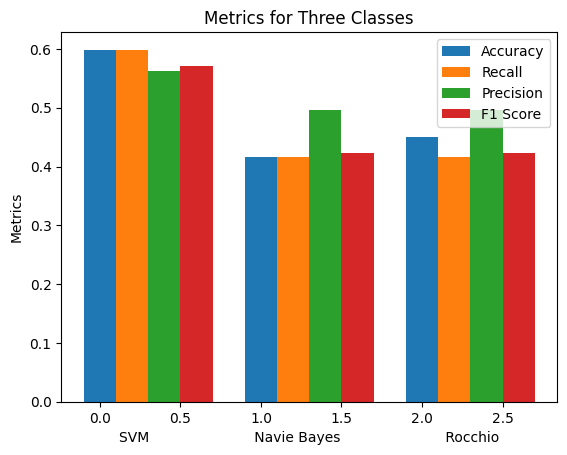

In [32]:
  # TODO: Plot evaulations
import matplotlib.pyplot as plt
import numpy as np

classes = ['SVM', 'Navie Bayes', 'Rocchio']
accuracy = [accuracy_svm, accuracy_gaussian_nb, accuracy_rocchio]
recall = [svm_recall, nb_recall, rocchio_recall]
precision = [svm_precision, nb_precision, rocchio_precision]
f1_score = [svm_fscore, nb_fscore, rocchio_fscore]

bar_width = 0.2

index = np.arange(len(classes))

plt.bar(index, accuracy, width=bar_width, label='Accuracy')
plt.bar(index + bar_width, recall, width=bar_width, label='Recall')
plt.bar(index + 2 * bar_width, precision, width=bar_width, label='Precision')
plt.bar(index + 3 * bar_width, f1_score, width=bar_width, label='F1 Score')

plt.xlabel('SVM                        Navie Bayes                        Rocchio')
plt.ylabel('Metrics')
plt.title('Metrics for Three Classes')
plt.legend()
plt.show()

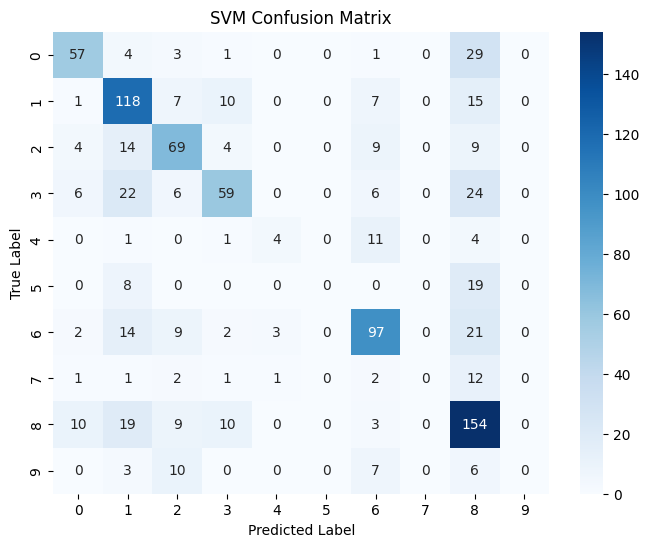

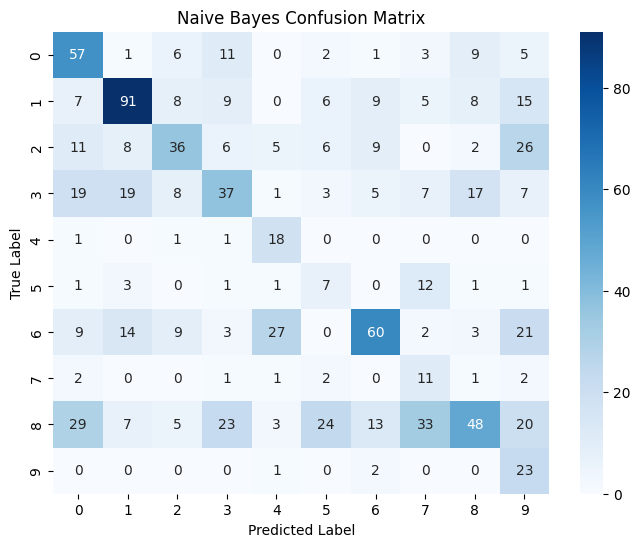

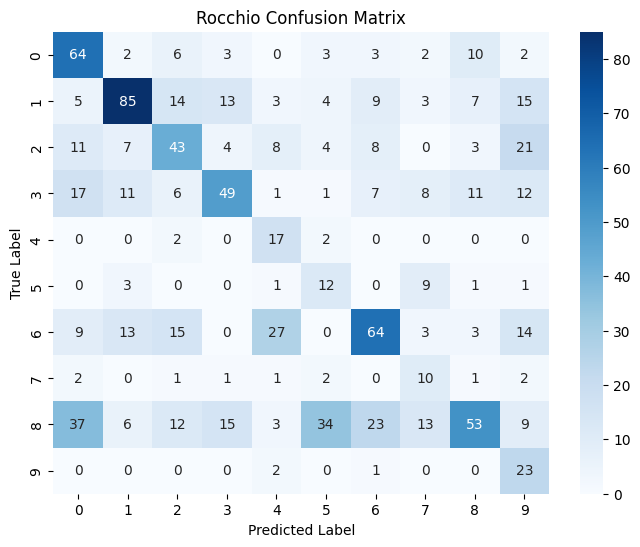

In [33]:
# TODO: Draw confusion matrix
def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

plot_confusion_matrix(svm_cm, classes=np.unique(Y_test), title="SVM Confusion Matrix")
plot_confusion_matrix(nb_cm, classes=np.unique(Y_test), title="Naive Bayes Confusion Matrix")
plot_confusion_matrix(rocchio_cm, classes=np.unique(Y_test), title="Rocchio Confusion Matrix")

<div dir="rtl">
کدام مدل از همه دقیق‌تر عمل کرد؟ نتیجه‌گیری و تحلیل خود از نتایج ارزیابی را گزارش دهید.
</div>

<span style="color: red;">SVM performs better than other classes. Because as we now, SVM has good performance in large datasets and we hjave a large dataset here. But Rocchio works better when dataset has well defined clusters and in this problem we do not have a well defind dataset (embeddings are not well defind). Also Naive bayes works well for small datasets, but here we have a large dataset. probabaly because of this reesons, SVM works better than other classifications.</span>


<div dir="rtl">
<h1>3.
کاهش ابعاد و خوشه‌بندی متن
</h1>
</div>

<div dir="rtl">
<h2>3-1.
کاهش ابعاد
</h2>
</div>

<div dir="rtl">
<h3>3-1-1.
PCA
</h3>
یکی از روش‌های کاهش ابعاد، PCA است. با استفاده از پیاده‌سازی آن در کتابخانه sklearn، ابعاد ویژگی‌های X را کاهش دهید.
<br>
سپس با استفاده از explained_variance_ratio_ در الگوریتم PCA  نشان دهید که با وجود یک ترشولد 90 درصد تا چه میزان میتوان ابعاد ویژگی ها را کم تر کرد.
</div>

In [34]:
from sklearn.decomposition import PCA

def reduce_dimension(embedding, n_components=None, variance_threshold=0.9):
    """
    Performs dimensional reduction using PCA with n components left behind
    Parameters
    ----------
    embeddings : List
        A list of embeddings of documents
    n_components: int
        Number of components to keep
    Returns a list of reduced embeddings
    """

    pca = PCA(n_components=n_components)
    reduced_embedding = pca.fit_transform(embedding)

    if n_components is None:
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance_ratio = explained_variance_ratio.cumsum()

        n_components = np.argmax(cumulative_variance_ratio >= variance_threshold) + 1
        print(f"Number of components to keep for {variance_threshold * 100}% variance: {n_components}")

        pca = PCA(n_components=n_components)
        reduced_embedding = pca.fit_transform(embedding)

    return reduced_embedding

reduced_X = reduce_dimension(embedded_X, n_components=None, variance_threshold=0.9)


Number of components to keep for 90.0% variance: 24


<div dir="rtl">
در این قسمت می‌توانید برای شهود بهتر، نمودار رسم کنید و همچنین برای ساده‌تر شدن کار، از pipeline‌های sklearn بهره ببرید.
<br>
<i> انجام این کار‌ها صرفا توصیه است و اجباری نیست. </i>
</div>

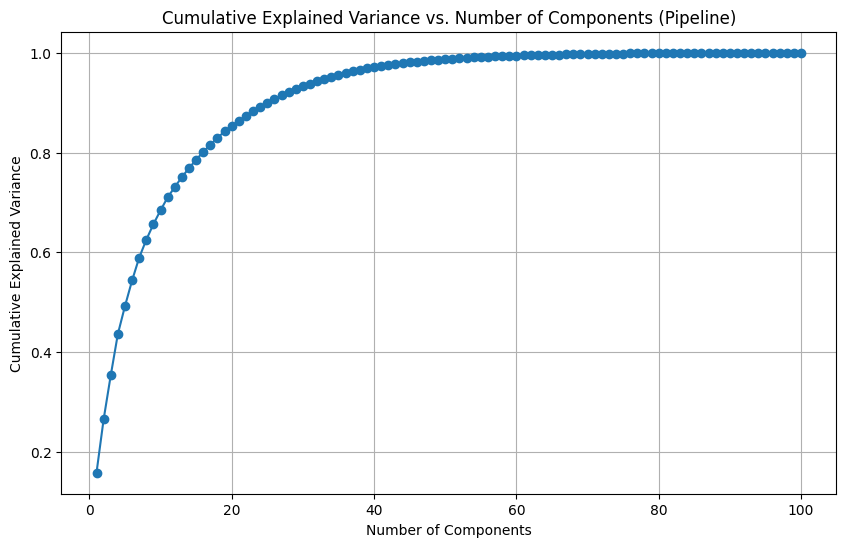

In [35]:
# TODO: Findout the most reduced dimension which has 90% cutoff explained variance.
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def reduce_dimension_with_pipeline(embedding, variance_threshold=0.9):
    pipeline = make_pipeline(StandardScaler(), PCA())

    pipeline.fit(embedding)

    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, pipeline.named_steps['pca'].n_components_ + 1),
             np.cumsum(pipeline.named_steps['pca'].explained_variance_ratio_), marker='o')
    plt.title('Cumulative Explained Variance vs. Number of Components (Pipeline)')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()

    reduced_embedding = pipeline.transform(embedding)

    return reduced_embedding

reduced_X_pipeline = reduce_dimension_with_pipeline(embedded_X, variance_threshold=0.9)


<div dir="rtl">
<h3>3-1-2.
TSNE
</h3>
<br>
     برای اینکه بتوانید در مراحل بعدی، نتایج خوشه‌بندی را مشاهده کنید، در این قسمت به پیاده‌سازی تابع کاهش بعد بردارهای جاسازی با استفاده از روش T-SNE می‌پردازید.
برای اینکار تابع convert_to_2d_tsne را پیاده‌سازی می‌کنید که لیستی از بردارهای جاسازی را به عنوان ورودی دریافت می‌کند و در خروجی، لیستی از بردارهای جاسازی کاهش بعد داده شده به دو بعد را تولید می‌کند. برای پیاده سازی این تابع می‌توانید از کتابخانه‌های آماده استفاده کنید.
<br>
توجه کنید که از بردارهای خروجی این قسمت <u>صرفا برای رسم نمودار</u> استفاده می‌کنید و تمامی مراحلی که در ادامه طی می‌کنید (به جز رسم نمودار)، باید با استفاده از بردارهای کاهش بعد داده <u>نشده</u> انجام شوند.
</div>


In [36]:
from typing import List
from sklearn.manifold import TSNE
def convert_to_2d_tsne(emb_vecs, n_runs=1):
    """
    Converts each raw embedding vector to 2d vector
    Parameters
    ----------
    emb_vecs : List
        A list of vectors
    Returns a list of 2d vectors
    """

    return TSNE(2, perplexity=50).fit_transform(emb_vecs)

# embedded_X_2d = convert_to_2d_tsne(embedded_X)

In [37]:
# TODO: Uncomment the following code
X_2d = convert_to_2d_tsne(np.array(embedded_X))

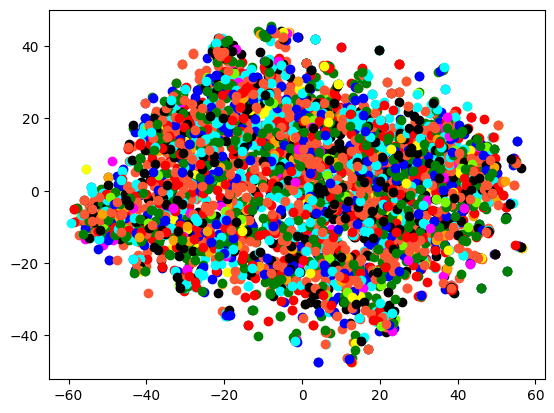

In [38]:
# I plot here
from matplotlib import cm
# print(len(set(Y_train)))
ax = plt.subplots()[1]
colors_list = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', '#FF5733', '#7CFC00']
for embedding, label in zip(X_2d, Y_train):
    ax.scatter(*embedding, c=colors_list[label])
plt.show()

<div dir="rtl">
<h2>3-2.
خوشه‌بندی
</h2>
</div>

<div dir="rtl">
<h3>3-2-1.
K-Means
</h3>

<div dir="rtl">
در این قسمت، شما ابتدا الگوریتم خوشه‌بندی K-means را
<u><b>از پایه</b></u>
 پیاده‌سازی می‌کنید.

</div>

In [79]:
from typing import List
import random

def cluster_kmeans(emb_vecs, n_clusters):
    """
    Clusters input vectors using K-means method
    Parameters
    -------
    emb_vecs : List
        A list of vectors

    n_clusters: int
        Number of clusters
    Returns
    -------
    list
        Two lists: 1) A list containing cluster centers 2) A list containing cluster index for each input vector
    """

    n_points = len(emb_vecs)
    cluster_centers = np.random.choice(n_points, size=n_clusters, replace=False)
    cluster_centers = emb_vecs[cluster_centers]
    cluster_index = np.zeros(n_points)
    num_iterations = 500
    for i in range(num_iterations):
        cluster_index = ((emb_vecs[:, np.newaxis, :] - cluster_centers) ** 2).sum(axis=2).argmin(axis=1)
        for j in range(n_clusters):
            cluster_centers[j] = emb_vecs[cluster_index == j].mean(axis=0)
    return cluster_centers, cluster_index.tolist()

<div dir="rtl">
 با استفاده از K-Means خوشه‌های اسناد را ایجاد کنید. الگوریتم را با استفاده از چند مقدار مختلف تعداد خوشه‌ها (k) اجرا کنید. در هربار اجرا، با استفاده از تعدادی از اسناد موجود در هر خوشه، موضوع آن خوشه را تعیین کرده و خوشه‌بندی حاصله را با استفاده از بردار‌های دوبعدی قسمت قبل، رسم کنید. با اینکار، پیاده‌سازی خود و همچنین کارایی این الگوریتم در خوشه‌بندی اسناد و قرار دادن اسناد مشابه در خوشه‌های یکسان را بررسی کنید.
<br>
 نمودار silhouette score برای مقدار‌های مختلف k را رسم کرده و silhouette analysis برای انتخاب k مناسب انجام دهید.
 همچنین با استفاده از داده‌های دارای برچسب، مقدار purity به ازای k را رسم کرده و مقدار purity برای k نهایی را گزارش کنید.
<br>
</div>

In [85]:
from sklearn.metrics import silhouette_score, cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def purity_score(y_true, y_pred):
    """
    Calculate the purity score for the given cluster assignments and ground truth classes
    y_true: list
        ground truth labels for each document
    y_pred: list
        predicted labels for each document
    Returns a purity score between 0.0 and 1.0 (higher is better)
    """
    # y_true, y_pred = y_true.tolist(), y_pred.tolist()
    total_true = 0
    for i in set(y_true):
        total_true += np.bincount(np.array(y_true)[y_pred == i]).max()
    return total_true / len(y_true)

In [101]:
# TODO: Calculate silhouette score and purity score
from sklearn.metrics import silhouette_score

def evaluate_kmeans(emb_vecs, k_values, true_labels):
    silhouette_scores = []
    purity_scores = []

    for k in k_values:
        cluster_centers, cluster_index = cluster_kmeans(emb_vecs, k)

        silhouette = silhouette_score(emb_vecs, cluster_index)
        silhouette_scores.append(silhouette)

        # print(cluster_index, len(cluster_index))
        # print(true_labels, len(true_labels))
        # purity = purity_score(true_labels, cluster_index)
        # purity_scores.append(purity)

        print(f"For k={k}, Silhouette Score: {silhouette}, Purity Score: {0}")
    return silhouette_scores, purity_scores

In [102]:
print(embedded_X[0])

[-0.02009342  0.32820864 -0.14647515  0.08767297  0.01992761  0.44036779
  0.06376581  0.13289553  0.11869472  0.03260842  0.03130103  0.08111293
  0.20256008  0.27933275 -0.16539465  0.26927721 -0.07275192 -0.22006448
  0.26598552  0.02087556  0.16456956  0.10760758  0.04667059 -0.21646581
  0.04569255  0.14785326  0.13772403 -0.02413107 -0.09620151  0.16033506
 -0.0657528   0.01377251 -0.33175632 -0.27557096 -0.20685672  0.23707689
  0.00954696  0.03515605  0.21829219  0.09295527  0.0712279  -0.22733603
  0.09535045 -0.10709583 -0.03722968  0.03674082  0.19172887  0.18339698
  0.06141822 -0.12490612 -0.16859685 -0.03429465 -0.07939248  0.30878353
 -0.19962759 -0.17765149 -0.11600585  0.30726353  0.00734881  0.20341704
 -0.04759389  0.02130087  0.01361723  0.13261532 -0.08819389  0.08519085
  0.06484691 -0.14003639 -0.2191783   0.12412797 -0.1904068  -0.19840758
 -0.0789364   0.15673139  0.26957109 -0.19133082  0.11743235 -0.11178672
  0.16103944  0.17007595  0.16226651 -0.0956025   0

In [103]:
embedded_X.shape
print(embedded_X[0])

min_value = np.min(embedded_X)
max_value = np.max(embedded_X)

normalized_array = (embedded_X - min_value) / (max_value - min_value)
print(normalized_array[0])

[-0.02009342  0.32820864 -0.14647515  0.08767297  0.01992761  0.44036779
  0.06376581  0.13289553  0.11869472  0.03260842  0.03130103  0.08111293
  0.20256008  0.27933275 -0.16539465  0.26927721 -0.07275192 -0.22006448
  0.26598552  0.02087556  0.16456956  0.10760758  0.04667059 -0.21646581
  0.04569255  0.14785326  0.13772403 -0.02413107 -0.09620151  0.16033506
 -0.0657528   0.01377251 -0.33175632 -0.27557096 -0.20685672  0.23707689
  0.00954696  0.03515605  0.21829219  0.09295527  0.0712279  -0.22733603
  0.09535045 -0.10709583 -0.03722968  0.03674082  0.19172887  0.18339698
  0.06141822 -0.12490612 -0.16859685 -0.03429465 -0.07939248  0.30878353
 -0.19962759 -0.17765149 -0.11600585  0.30726353  0.00734881  0.20341704
 -0.04759389  0.02130087  0.01361723  0.13261532 -0.08819389  0.08519085
  0.06484691 -0.14003639 -0.2191783   0.12412797 -0.1904068  -0.19840758
 -0.0789364   0.15673139  0.26957109 -0.19133082  0.11743235 -0.11178672
  0.16103944  0.17007595  0.16226651 -0.0956025   0

(4657,)
For k=2, Silhouette Score: 0.1383195955494892, Purity Score: 0
For k=3, Silhouette Score: 0.08949587794223879, Purity Score: 0
For k=4, Silhouette Score: 0.06638137606238288, Purity Score: 0
For k=5, Silhouette Score: 0.0687625646742389, Purity Score: 0
For k=6, Silhouette Score: 0.0720172372784749, Purity Score: 0
For k=7, Silhouette Score: 0.06159330748213671, Purity Score: 0
For k=8, Silhouette Score: 0.05242165685212872, Purity Score: 0
For k=9, Silhouette Score: 0.057990243825611916, Purity Score: 0


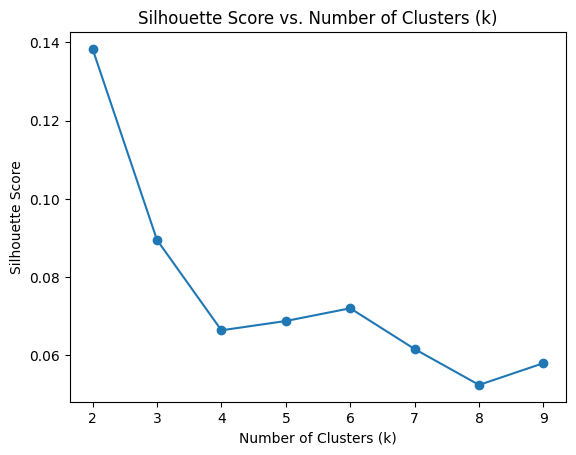

In [106]:
# TODO: Plot silhouette score for different value of k (at least 5 different k values)
k_values = [i for i in range(2, 10)]
Y_true = np.array(Y_train.tolist() + Y_test.tolist())
print(Y_true.shape)
silhouette_scores, purity_scores = evaluate_kmeans(normalized_array, k_values, Y_true)
plt.figure()
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

In [105]:
#TODO: plot purity for different value of k (at least 5 different k values)

<div dir="rtl">
با استفاده از نمودارهای رسم شده توضیح دهید بهترین k برای انتخاب در داده ما با استفاده از الگوریتم K-Means چیست؟
چرا؟
</div>

<span style="color: red;">My answer is not correct I think, although I can not find its bug. But I think when K increases, silhouette_scores will decrease, that is beacuse silhouette_scores are measurment of farness of centroids together and if k increases centroids will be closer to each other.</span>

> Indented block



<div dir="rtl">
<h3>3-2-2.
Hierarchical clustering
</h3>
</div>

<div dir="rtl">
تکنیک خوشه‌بندی سلسله مراتبی یکی از تکنیک‌های خوشه‌بندی در یادگیری ماشین است. در این قسمت شما می‌توانید از لایببری scipy یا هر لایبرری دیگری در پایتون استفاده کنید تا داده‌ها را به صورت سلسله‌مراتبی خوشه‌بندی کنید. سپس می‌توانید خوشه‌ها را با matplotlib مشاهده کنید.
</div>

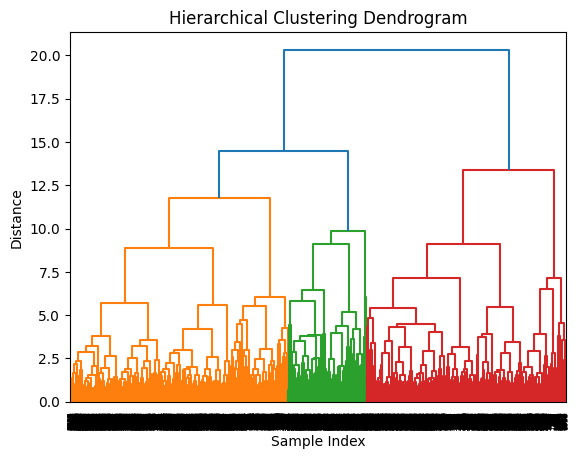

In [45]:
# TODO: Perform hierarchical clustering on X
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

linkage_matrix = linkage(embedded_X, method='ward')  # You can choose a different method if needed

dendrogram(linkage_matrix, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# clusters = 10
# cluster_labels = fcluster(linkage_matrix, t=clusters, criterion='distance')

